In [1]:
import geopandas as gpd
from engine import *
from tqdm import tqdm


In [2]:
### Cargamos datos
agebs = gpd.read_file("agebs_ZM_de_Querétaro.geojson")
## Calculamos el centroide de cada ageb
agebs["centroide"] = agebs["geometry"].centroid


<ipython-input-2-dc8cff704573>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  agebs["centroide"] = agebs["geometry"].centroid


<AxesSubplot:>

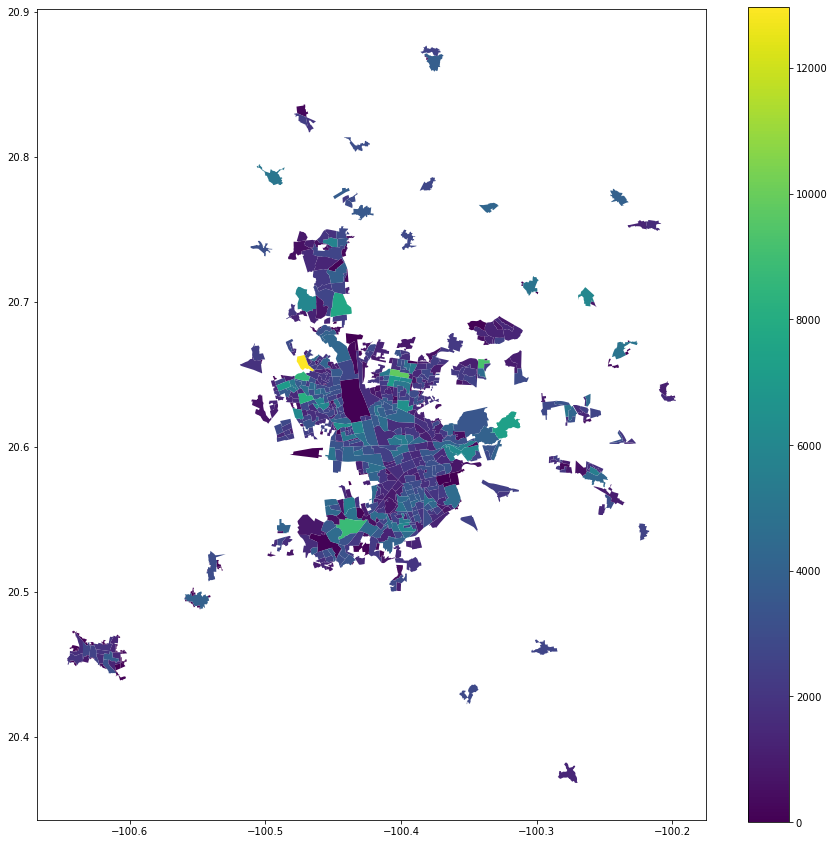

In [3]:
### Vemos el mapa
agebs.plot(column='POBTOT',figsize=(15, 15), legend=True)

In [4]:
### Observamos las primeras 20 columnas
agebs['PRESOE15']=agebs['PRESOE15'].apply(lambda x : float(str(x).replace("*","1.5")))


In [182]:
agebs['POBTOT'].describe()

count      666.000000
mean      2127.474474
std       1694.046904
min          0.000000
25%        896.000000
50%       1843.500000
75%       3013.250000
max      12975.000000
Name: POBTOT, dtype: float64

In [5]:

## Obtenemos la matriz de adjacencia de los vecinos de los agebs
print("%-------------------------------------------------------------%")
print("Obtenemos la matriz de adjacencia de los vecinos de los agebs")
print("%--------------------------------------------------------------%")

adyacencia_dic = layer2net(agebs)


  1%|          | 4/666 [00:00<00:20, 32.17it/s]

%-------------------------------------------------------------%
Obtenemos la matriz de adjacencia de los vecinos de los agebs
%--------------------------------------------------------------%


100%|██████████| 666/666 [00:20<00:00, 31.79it/s]


In [ ]:
np.array([adyacencia_dic[i] for i in adyacencia_dic.keys()])
import pickle

with open('adyacencia_dic.pickle', 'wb') as handle:
    pickle.dump(adyacencia_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
with open('adyacencia_dic.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [276]:
### Definimos las clases y sus atributos
class Ageb:
    def __init__(self,cvegeo,poblacion,geometria,vivienda,inmigrantes,centroide):
        self.cvegeo = cvegeo
        self.poblacion = {0 : poblacion}
        self.vivienda = {0 : vivienda}
        self.inmigrantes = {0 : inmigrantes}
        self.densidad_poblacional = {}
        self.vecinos = []
        self.geometria  = geometria
        self.centroide = centroide
        self.proba_ocupacion_inicial = {"juriquilla" : 0,"pi_bj" : 0,'elpueblito':0}
        self.proba_ocupacion_min = 0
        self.distancia_vecino = {}
        self.ruta_vecino = {}
        self.distancias_cbd = {"juriquilla" : 0,"pi_bj" : 0,'elpueblito':0}
        self.distancias_min_cbd = 0
        self.poblacion_migrante = {}
        self.probabilidad_inmigracion = {}
        self.probabilidad_ocup_total = {}
        
    def crec_nat_pob_log_continuo(self,k,K,t):
        try:
            A=(K-self.poblacion[t-1])/self.poblacion[t-1]
            P=K/(1+A*np.exp(-k*t))
            self.poblacion[t] = P 
        except Exception as e: 
            self.poblacion[t] = 0

    def crec_nat_viv_log_continuo(self,k,K,t):
        try:
            A=(K-self.vivienda[t-1])/self.vivienda[t-1]
            P=K/(1+A*np.exp(-k*t))
            self.vivienda[t] = P 
        except Exception as e: 
            self.vivienda[t] = self.vivienda[t-1]
            
    def verifica_umbral(self,rho_critica,Delta_r1,Delta_r2,t):
        # Calculamos el indicador de saturación rho
        
        rho = self.calcula_rho(t)
        
        if rho >rho_critica:
            p_r = self.poblacion[t] -(rho_critica*self.vivienda[t])
            p_re=p_r*np.random.uniform(Delta_r1,Delta_r2)
            self.poblacion[t] = self.poblacion[t]-p_re
            self.poblacion_migrante[t]=p_re
            
            return p_re
        
        return 0
    
    def calcula_proba_inmigracion(self,t):
        try:
            p_I= self.inmigrantes[t]/self.poblacion[t]
            self.probabilidad_inmigracion[t] = p_I

            #return p_I

        except Exception as e:
            self.probabilidad_inmigracion[t] = 0
            
            #return 0   
        
    def calcula_probabilidad_ocupacion(self,t):
        p_O = self.probabilidad_inmigracion[t] +  self.proba_ocupacion_min
        self.probabilidad_ocup_total[t]= p_O

        return p_O
    
    def actualiza_probabilidad_ocupacion(self,t,p_O_suma):
        p_O = self.probabilidad_ocup_total[t]
        self.probabilidad_ocup_total[t] = p_O/p_O_suma
        
        #return p_O/p_O_suma

            
    def calcula_rho(self,t):
        try:
            rho = self.poblacion[t]/self.vivienda[t]
            self.densidad_poblacional[t] = rho
            
            return rho
        except Exception as e: 
            self.densidad_poblacional[t] = 0
            return 0
        
    def reparte_poblacion_migrante(self,t,p_re):
        self.poblacion[t]= self.poblacion[t] + (self.probabilidad_ocup_total[t]*p_re)

class Network:
    
    def __init__(self):
        self.agebs ={}

    def plot_poblacion(self,t):
        poblacion_lista = []
        cvegeo_lista = []
        geometria_lista = []
        for ageb_cvegeo,ageb in self.agebs.items():
            geometria_lista.append(ageb.geometria)
            poblacion_lista.append(ageb.poblacion[t])
            cvegeo_lista.append(ageb_cvegeo)
        df = pd.DataFrame({"cvegeo":cvegeo_lista,'poblacion': poblacion_lista,"geometry":geometria_lista})
        gdf = gpd.GeoDataFrame(df, geometry='geometry')
        gdf.plot(column='poblacion',figsize=(10, 10), legend=True)

In [277]:
# Instancia de la clase Network()
agebs_net = Network()

# Agregamos las instancias de cada ageb en el diccionacio de agebs_net
print("%-------------------------------------------------------------%")
print("Agregamos las instancias de cada ageb en el diccionacio de agebs_net")
print("%--------------------------------------------------------------%")
for ageb in tqdm(list(adyacencia_dic.keys())):
    poblacion = agebs[agebs["CVEGEO"]==ageb]["POBTOT"].item()
    geometria = agebs[agebs["CVEGEO"]==ageb]["geometry"].item()
    vivtot = agebs[agebs["CVEGEO"]==ageb]["VIVTOT"].item()
    inmigrantes = agebs[agebs['CVEGEO']==ageb]["PRESOE15"].item() 
    centroide = agebs[agebs["CVEGEO"]==ageb]["centroide"].item()
    agebs_net.agebs[ageb]=Ageb(ageb,poblacion,geometria,vivtot,inmigrantes,centroide)

# Agregamos los vecinos de cada ageb
print("%-------------------------------------------------------------%")
print("Agregamos los vecinos de cada ageb")
print("%--------------------------------------------------------------%")
for ageb in tqdm(list(adyacencia_dic.keys())):
    lista_vecinos = list(np.where((adyacencia_dic[ageb]==1))[0])
    ref_vecinos = []

    if len(lista_vecinos)==0:
        pass
    else:
        for vecino in np.take(list(agebs_net.agebs.keys()),lista_vecinos):
            ref_vecinos.append(agebs_net.agebs[vecino])
        agebs_net.agebs[ageb].vecinos=ref_vecinos


  0%|          | 2/666 [00:00<00:34, 19.38it/s]

%-------------------------------------------------------------%
Agregamos las instancias de cada ageb en el diccionacio de agebs_net
%--------------------------------------------------------------%


100%|██████████| 666/666 [00:00<00:00, 10063.94it/s]

%-------------------------------------------------------------%
Agregamos los vecinos de cada ageb
%--------------------------------------------------------------%


In [278]:
### Diccionario de principales destinos de trabajo
destinos = {"zocalo": (19.432229587797913, -99.13342540255914),
            "condesa" :(19.41500702816897, -99.17754326239348),
            "reforma" : (19.42631517782024, -99.19379876201027),
            "delValle": (19.373937627246054, -99.17861804875692),
            "viveros": (19.35420491791415, -99.17548474041028),
            "vallejo" : (19.49489893376003, -99.1647650982302),
            "cu": (19.322740688438223, -99.1866604705067),
            "polanco" : (19.433666445182244, -99.19094770204629),
            "santafe" : (19.361383705434182, -99.27367230390125)}

destinos_qro = {'juriquilla':(20.70328832963603, -100.45315166039546),
                'pi_bj': (20.63738283212626, -100.4281830983263),
                'elpueblito': (20.539299465897976, -100.4385583226433)}          

In [279]:
### Definimos función para calcular distancia geodésica
import geopy.distance

def get_distancias(origen,destino):
    origen = tuple(reversed(origen.centroide.coords[0]))
    dist = geopy.distance.geodesic(origen,destino)
    
    return dist.meters

### Ejemplo
get_distancias(agebs_net.agebs['220140001038A'], (20.63738283212626, -100.4281830983263))


6220.1832104243385

In [280]:
### Obtenemos las distancias con respecto a los centros laborales 
for key_ageb,ageb in tqdm(agebs_net.agebs.items()):
    for k,v in destinos_qro.items():
        ageb.distancias_cbd[k]=get_distancias(ageb,v)
        
### Verificamos con un ageb
agebs_net.agebs['220140001038A'].distancias_cbd

100%|██████████| 666/666 [00:00<00:00, 2058.37it/s]


{'juriquilla': 13736.99935359061,
 'pi_bj': 6220.1832104243385,
 'elpueblito': 7993.537314465594}

In [281]:
for key_ageb,ageb in tqdm(agebs_net.agebs.items()):
    ageb.distancias_min_cbd= min(ageb.distancias_cbd.values())

## Probamos
agebs_net.agebs['220140001038A'].distancias_min_cbd,agebs_net.agebs['220140001038A'].distancias_cbd

100%|██████████| 666/666 [00:00<00:00, 789543.94it/s]


(6220.1832104243385,
 {'juriquilla': 13736.99935359061,
  'pi_bj': 6220.1832104243385,
  'elpueblito': 7993.537314465594})

100%|██████████| 666/666 [00:00<00:00, 755587.36it/s]


<AxesSubplot:>

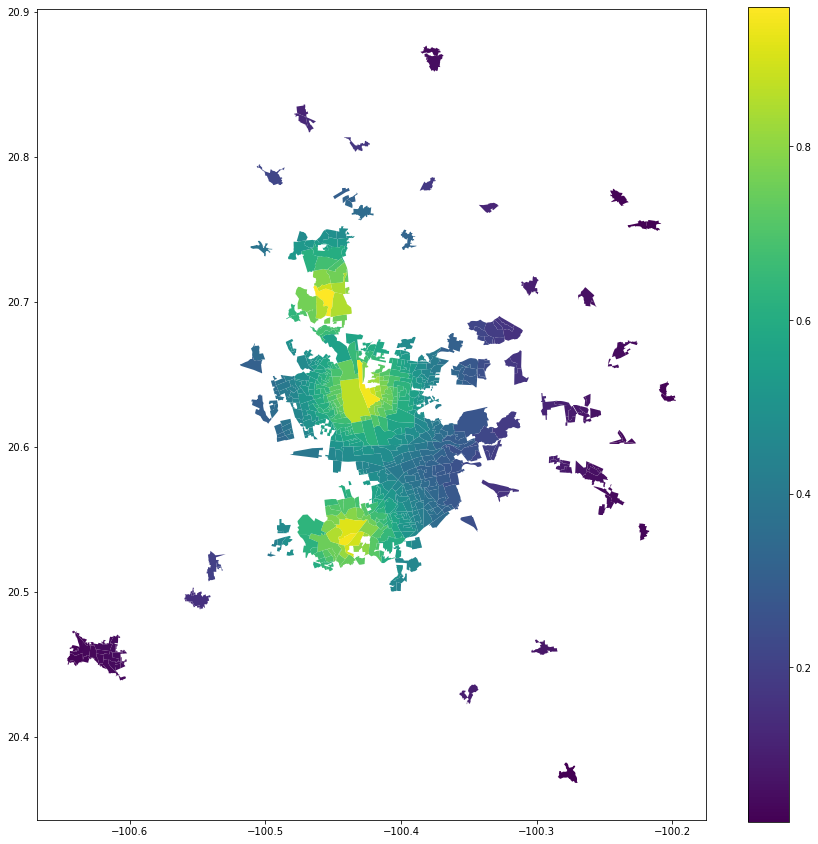

In [326]:
## Exponencial 1
### Calculamos la probabilidad inicial de cada ageb
b = 15

for key_ageb,ageb in tqdm(agebs_net.agebs.items()):
    r = ageb.distancias_min_cbd/100000
    ageb.proba_ocupacion_min=np.exp(-b*r)
#### Guardamos la probabilidad inicial con respecto juriquilla
proba_lista = []

for key_ageb,ageb in tqdm(agebs_net.agebs.items()):
    proba_lista.append(ageb.proba_ocupacion_min)
    
df = pd.DataFrame({"cvegeo":agebs['CVEGEO'],'proba_inicial': proba_lista,"geometry":agebs['geometry']})
gdf = gpd.GeoDataFrame(df, geometry='geometry')

gdf.plot(column='proba_inicial',figsize=(15, 15), legend=True)

100%|██████████| 666/666 [00:00<00:00, 897624.19it/s]


<AxesSubplot:>

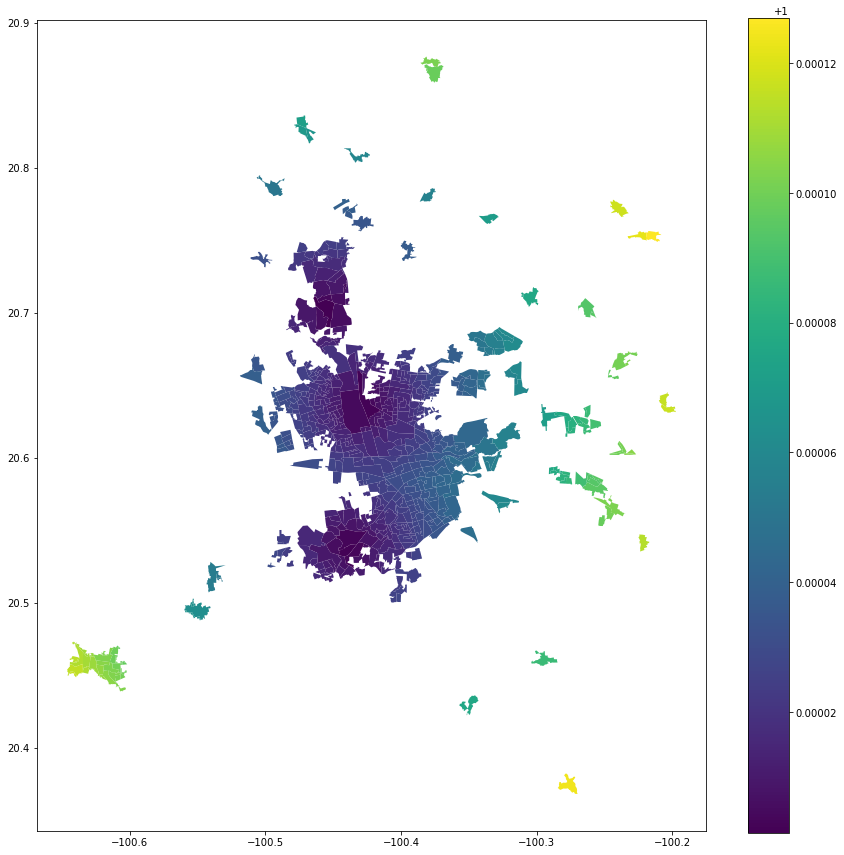

In [283]:
## Exponencial 2
### Calculamos la probabilidad inicial de cada ageb
b = 0.005
c = 0.0002
for key_ageb,ageb in tqdm(agebs_net.agebs.items()):
    r = ageb.distancias_min_cbd/1000000
    ageb.proba_ocupacion_min=np.exp(b*r-c*r**2) 
ageb.proba_ocupacion_min

#### Guardamos la probabilidad inicial con respecto juriquilla
proba_lista = []

for key_ageb,ageb in tqdm(agebs_net.agebs.items()):
    proba_lista.append(ageb.proba_ocupacion_min)
    
df = pd.DataFrame({"cvegeo":agebs['CVEGEO'],'proba_inicial': proba_lista,"geometry":agebs['geometry']})
gdf = gpd.GeoDataFrame(df, geometry='geometry')

gdf.plot(column='proba_inicial',figsize=(15, 15), legend=True)

$\textbf{Modelo de crecimiento}$

Dado el AGEB $i$, con población $P_i$ y número de viviendas $V_i$, su densidad poblacional esta dada por

$$\rho_i=\frac{P_i}{V_i}.$$

La población puede crecer siguiendo un modelo logístico discreto

$$P_i(t)=\frac{K}{1+Ae^{-k(t)}},$$

con 

$$A=\frac{K-P_0}{P_0},$$

tasa de crecimiento $k\in\mathbb{R}$, y capacidad de carga $K\in\mathbb{R}$.

$\sigma_i,k\in\mathbb{R}$, o un crecimiento proporcional a la población
$$P_i(t+1)=P_i(t)+P_i(t)\delta,$$

con $\delta\in[0,\delta_{\text{max}}]$, un número aleatorio escogido siguiendo una distribución normal y $\delta_{\text{max}}\in\{1,2\}$.

La vivienda puede aumentar de manera constante
$$V_i(t+1)=V_i(t)+c.$$

con $c\in\mathbb{N}$. 

In [327]:
import matplotlib.pyplot as plt 

T=100
#r=4
k_pob= 0.1
K_pob= 6500
k_viv= 0.01
K_viv= 1000
rho_critica=6
Delta_r1= 0.6
Delta_r2= 0.9
b = 15
l_pob = []
l_viv = []
l_p_re = []
l_p_O_suma = []
## La población de todos los agebs crece al 2% por 10 periodos
for t in tqdm(range(1,50)):
    suma_pob = 0
    suma_viv = 0
    suma_p_re = 0
    p_O_suma = 0
    suma_probabilidad_ocupacion=0
    for ageb in agebs_net.agebs:
        if t==0:
            r = ageb.distancias_min_cbd/100000
            ageb.proba_ocupacion_min=np.exp(-b*r)
        ### Crecimiento natural
        # Logístico Continuo para población
        agebs_net.agebs[ageb].crec_nat_pob_log_continuo(k_pob,K_pob,t)
        # Logístico Continuo para vivienda
        agebs_net.agebs[ageb].crec_nat_viv_log_continuo(k_viv,K_viv,t)        
        suma_pob+=agebs_net.agebs[ageb].poblacion[t]
        suma_viv+=agebs_net.agebs[ageb].vivienda[t]
        # Checar criterio de expulsión
        suma_p_re+=agebs_net.agebs[ageb].verifica_umbral(rho_critica,Delta_r1,Delta_r2,t)
        # Calcular probabilidad de inmigración
        agebs_net.agebs[ageb].calcula_proba_inmigracion(t)
        # Calcula probalidiad de ocupación
        p_O = agebs_net.agebs[ageb].calcula_probabilidad_ocupacion(t)
        p_O_suma += p_O
    # Normaliza probabilidad de ocupación
    for ageb in agebs_net.agebs:
        agebs_net.agebs[ageb].actualiza_probabilidad_ocupacion(t,p_O_suma)
        suma_probabilidad_ocupacion+=agebs_net.agebs[ageb].probabilidad_ocup_total[t]
        ## Se reparte población expulsada
        agebs_net.agebs[ageb].reparte_poblacion_migrante(t,suma_p_re)
        
    
    l_pob.append(suma_pob)
    l_viv.append(suma_viv)
    l_p_re.append(suma_p_re)
agebs_net.agebs['220140001038A'].poblacion

  0%|          | 0/49 [00:00<?, ?it/s]<ipython-input-276-93690e22e878>:80: RuntimeWarning: divide by zero encountered in double_scalars
  rho = self.poblacion[t]/self.vivienda[t]
100%|██████████| 49/49 [00:00<00:00, 127.25it/s]


{0: 1493,
 1: 1612.9616039936836,
 2: 1868.0366584296141,
 3: 2292.6905937543956,
 4: 2939.616005310046,
 5: 3876.0072001617646,
 6: 4644.501139906642,
 7: 5165.188241957275,
 8: 5354.873535280051,
 9: 5571.637329636277,
 10: 6020.5410588578225,
 11: 6149.305593482006,
 12: 6019.40891495064,
 13: 6414.292004037717,
 14: 6225.075868413365,
 15: 6668.814023301486,
 16: 6787.101861728941,
 17: 6595.501257418152,
 18: 6606.934274559635,
 19: 6601.584326622986,
 20: 6888.869200337658,
 21: 6904.900136298934,
 22: 6708.43322703822,
 23: 6876.357281429608,
 24: 6915.536253424871,
 25: 6891.661669521623,
 26: 6733.697239994266,
 27: 6699.455800628714,
 28: 6711.026506709971,
 29: 6762.507313641503,
 30: 6721.750415176603,
 31: 6701.688592342725,
 32: 6598.35584144141,
 33: 6692.396105635966,
 34: 6574.329773239073,
 35: 6619.038684000223,
 36: 6632.309166373248,
 37: 6618.886510938683,
 38: 6556.152573375985,
 39: 6492.646954428747,
 40: 6486.9075371201225,
 41: 6553.270660751739,
 42: 6490.61

Text(0, 0.5, 'Población')

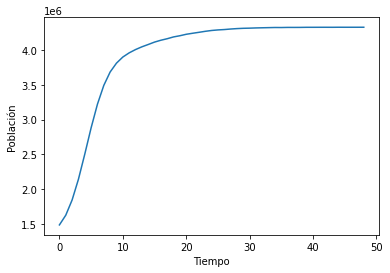

In [328]:

plt.plot(l_pob) 
min(l_pob)
plt.xlabel('Tiempo')
plt.ylabel('Población') 

Text(0, 0.5, 'vivienda')

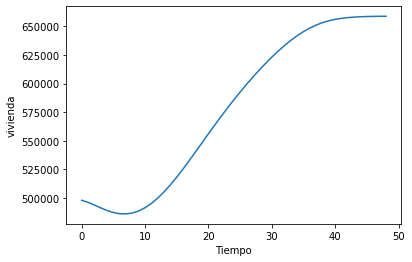

In [329]:
plt.plot(l_viv) 
min(l_viv)
plt.xlabel('Tiempo')
plt.ylabel('vivienda') 

Text(0, 0.5, 'p_re')

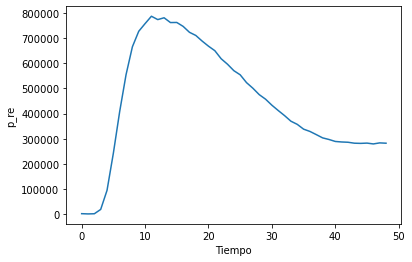

In [330]:
plt.plot(l_p_re) 
min(l_p_re)
plt.xlabel('Tiempo')
plt.ylabel('p_re')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


/home/milo/anaconda3/envs/crecurb/lib/python3.8/site-packages/geopandas/plotting.py:658: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


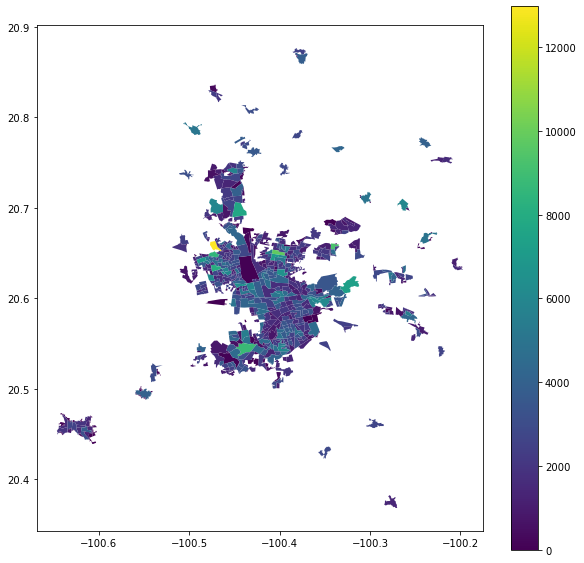

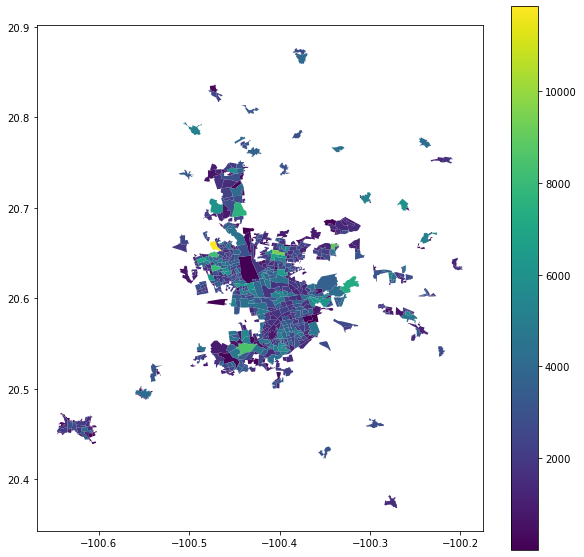

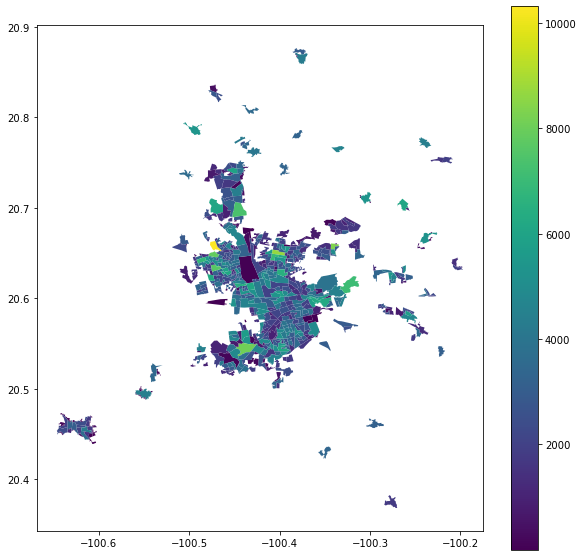

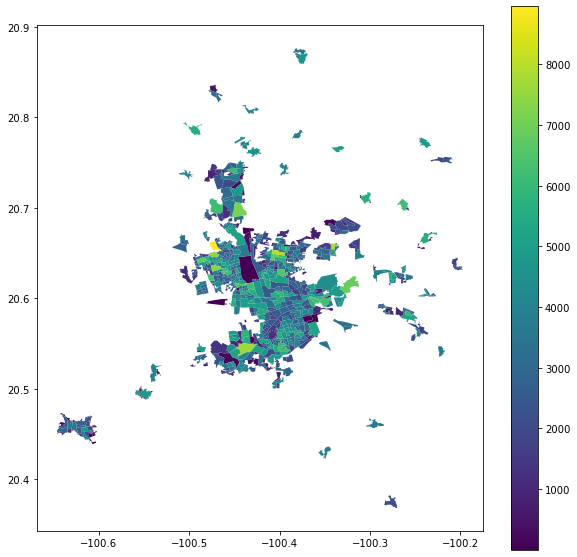

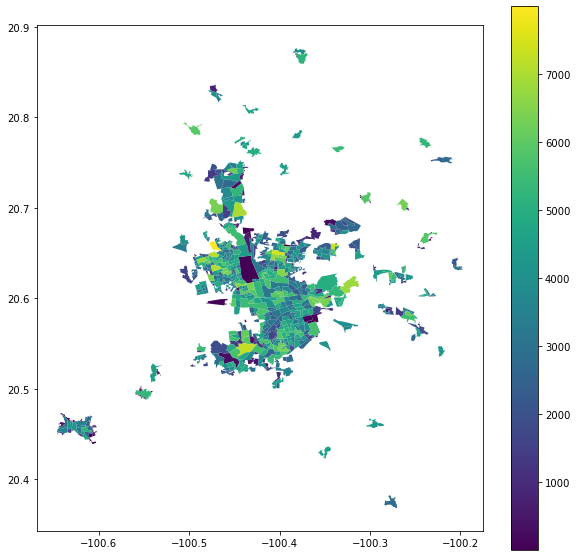

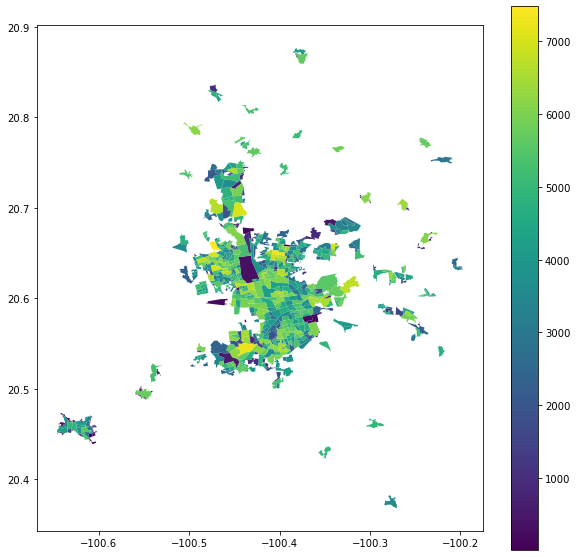

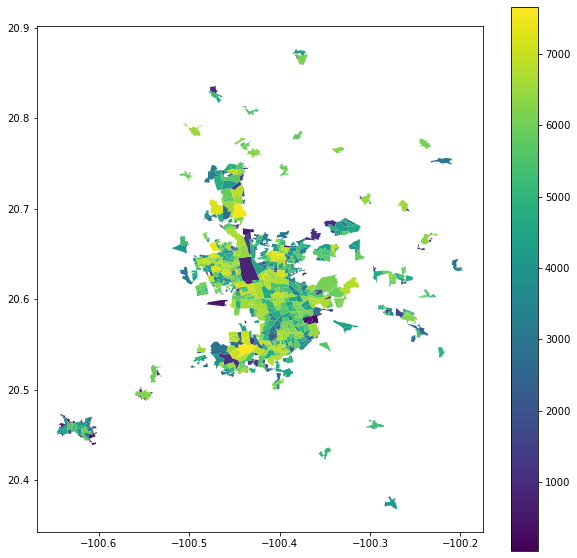

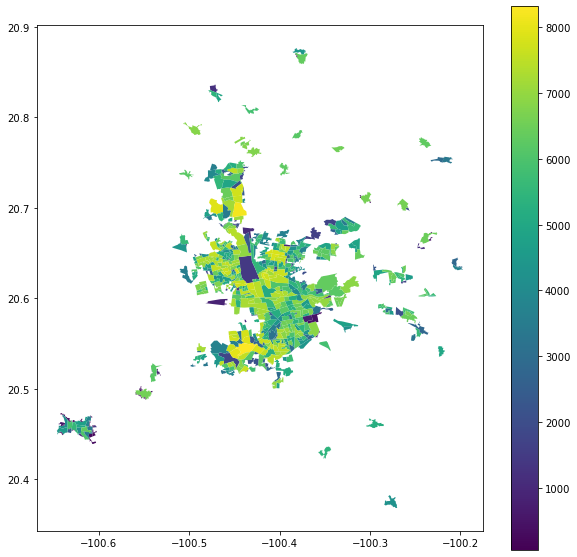

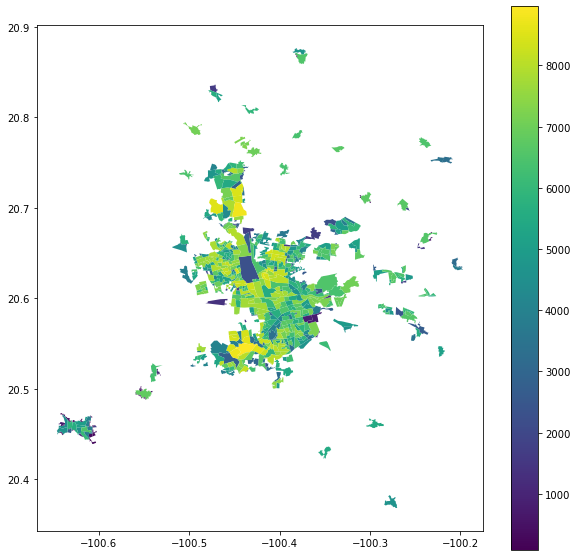

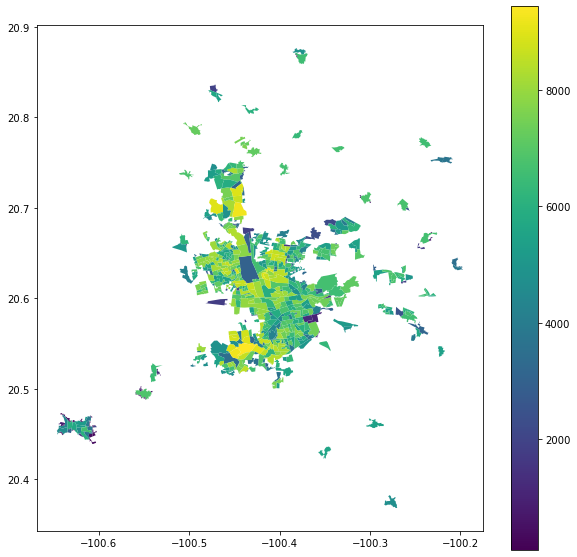

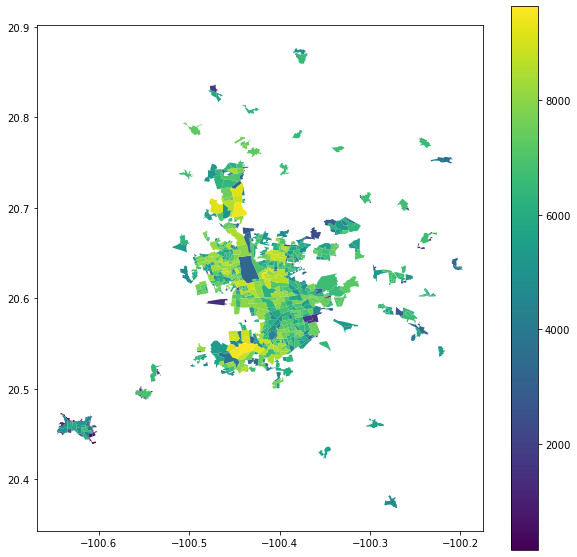

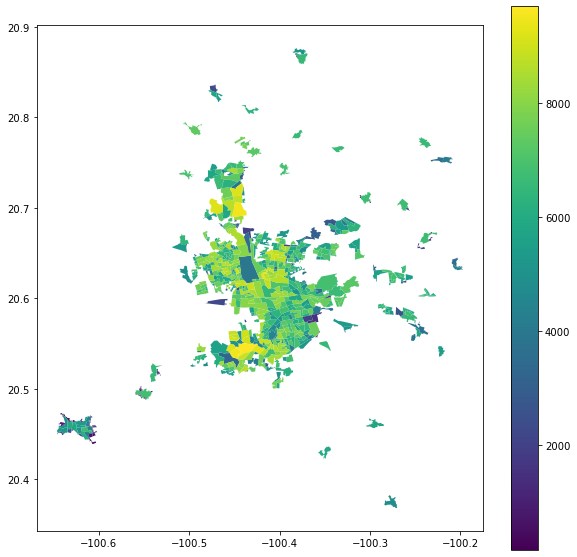

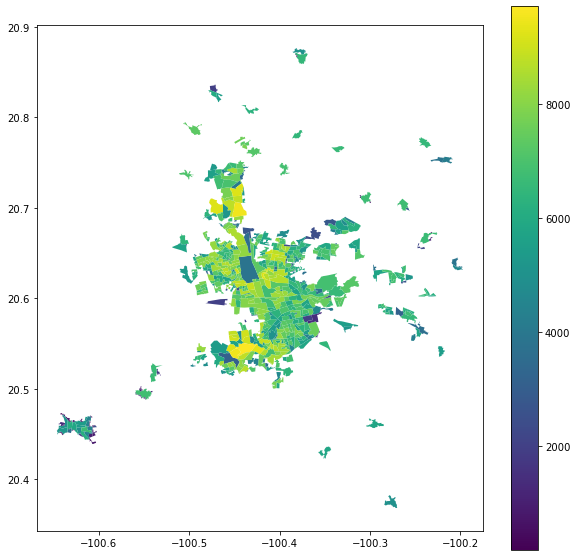

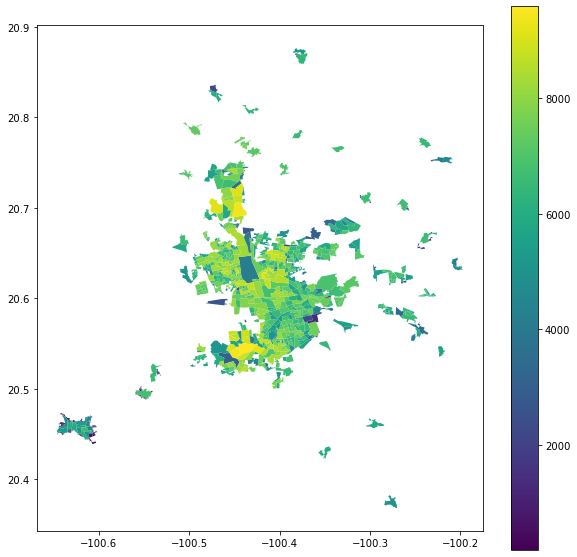

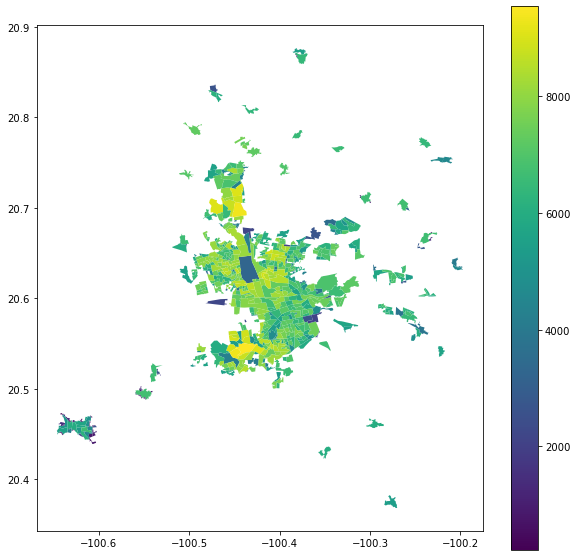

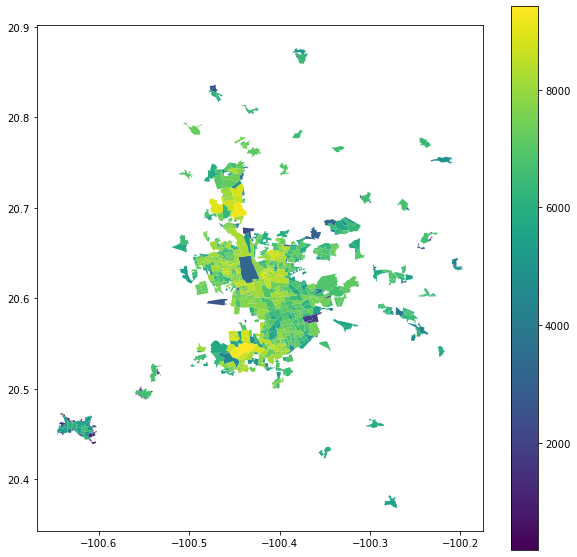

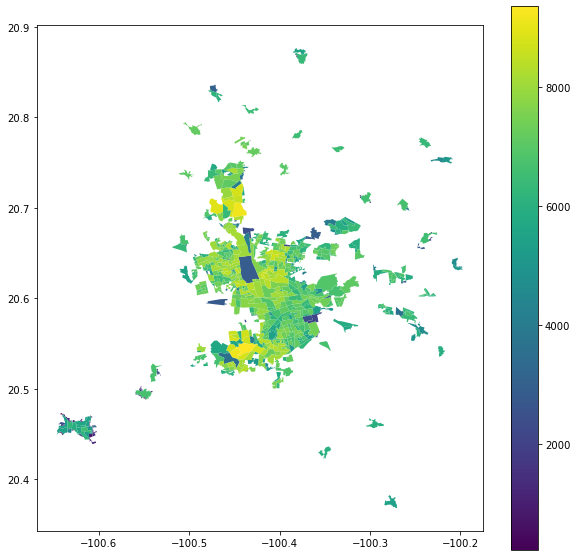

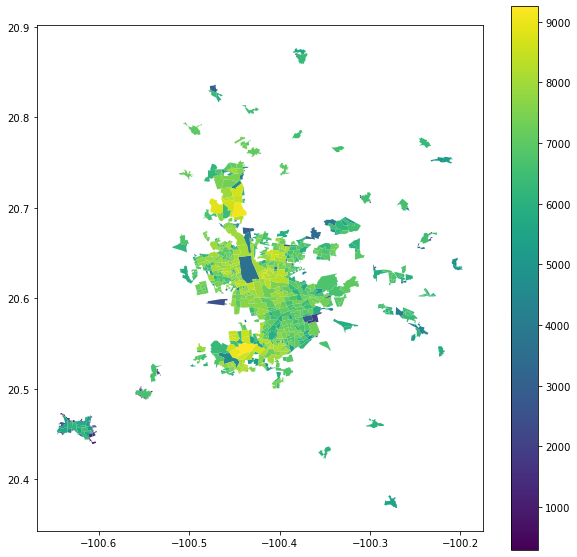

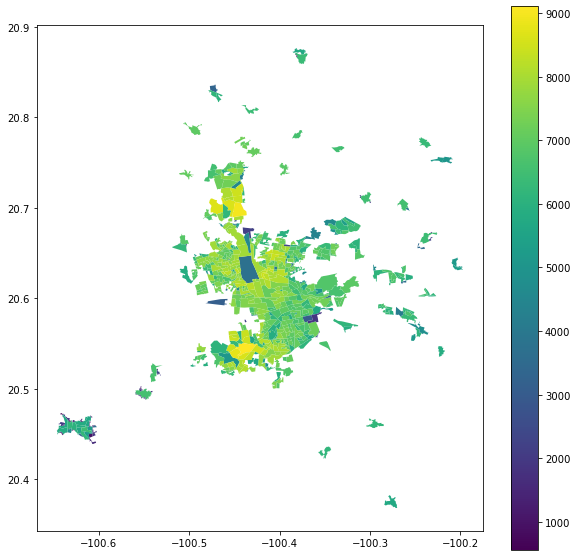

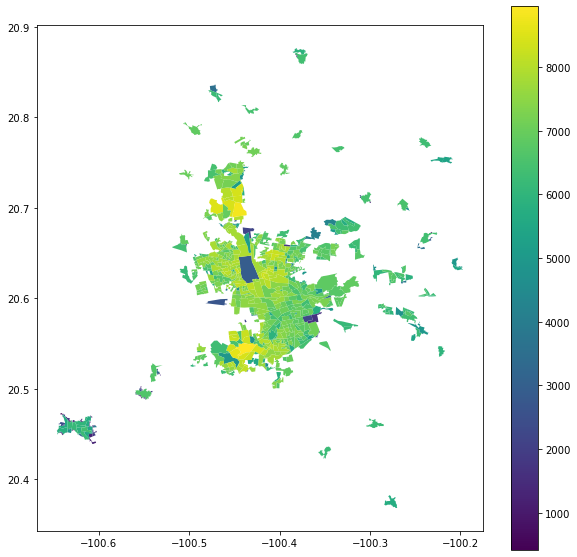

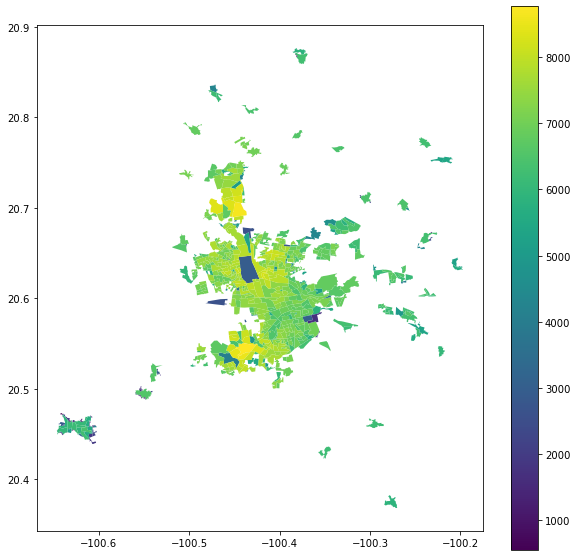

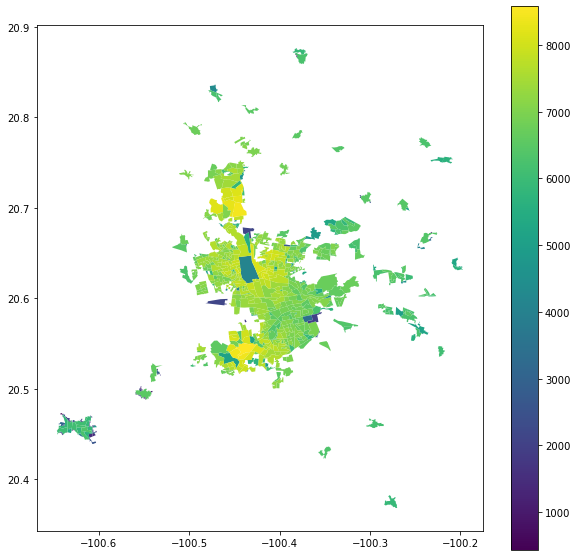

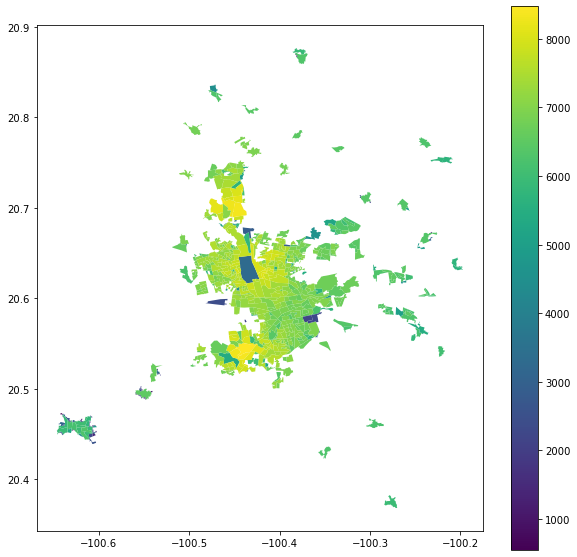

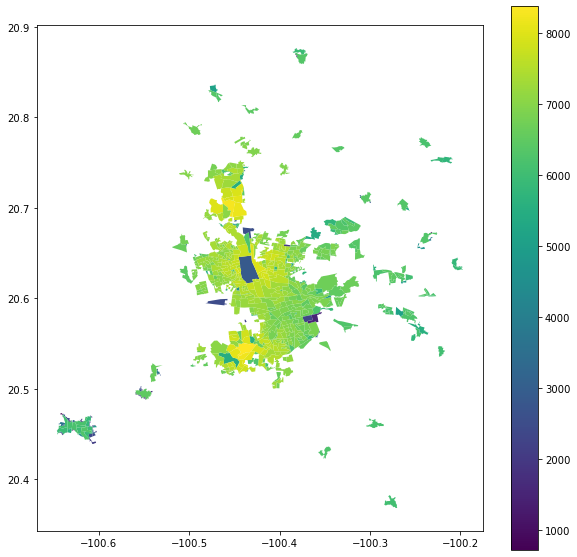

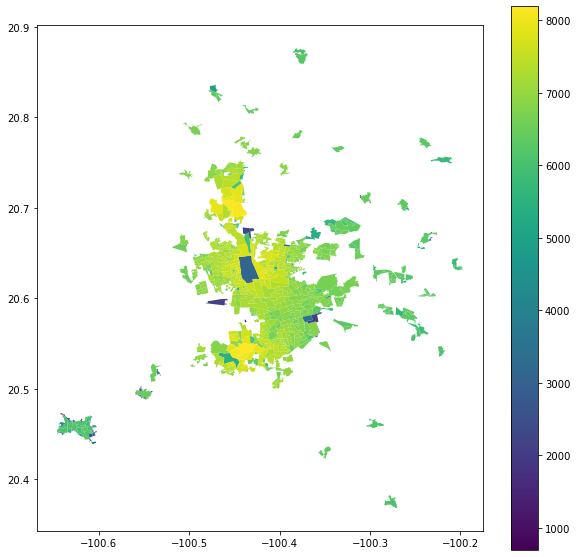

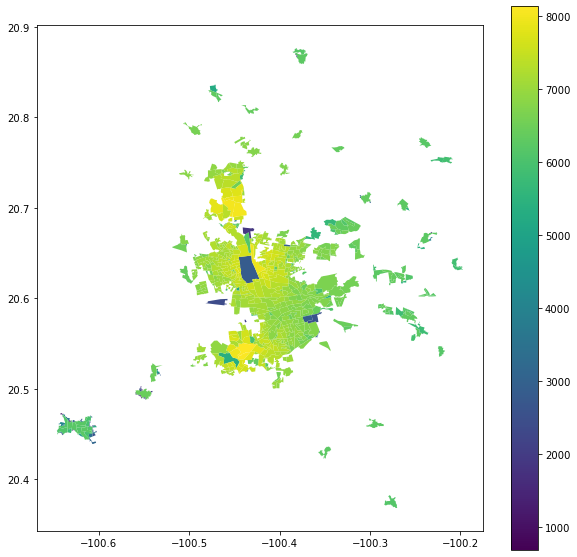

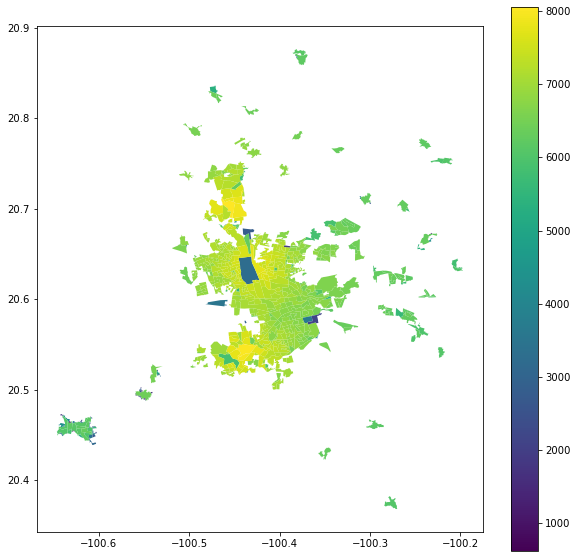

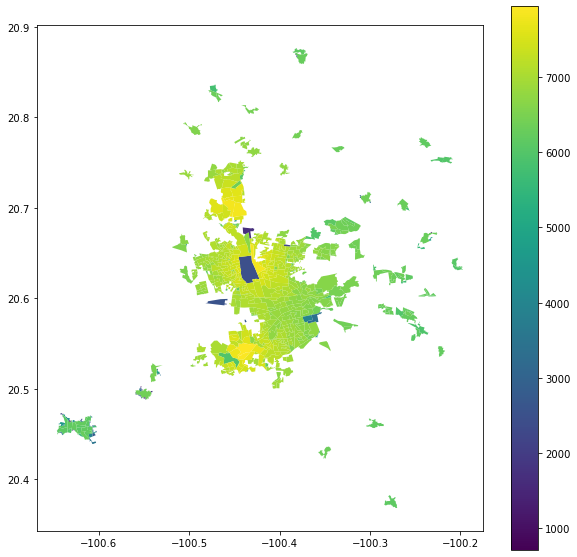

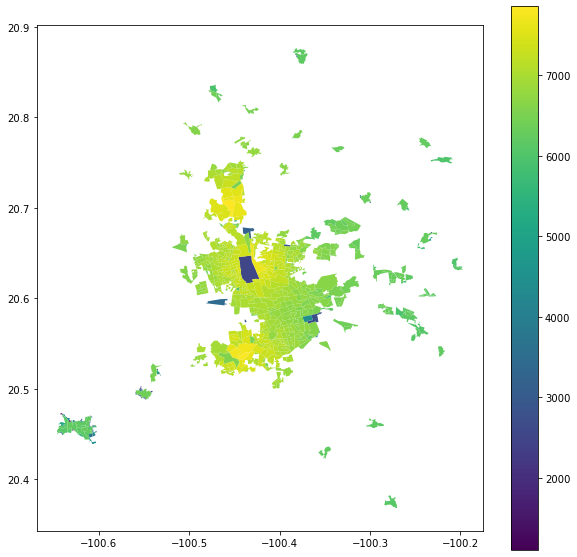

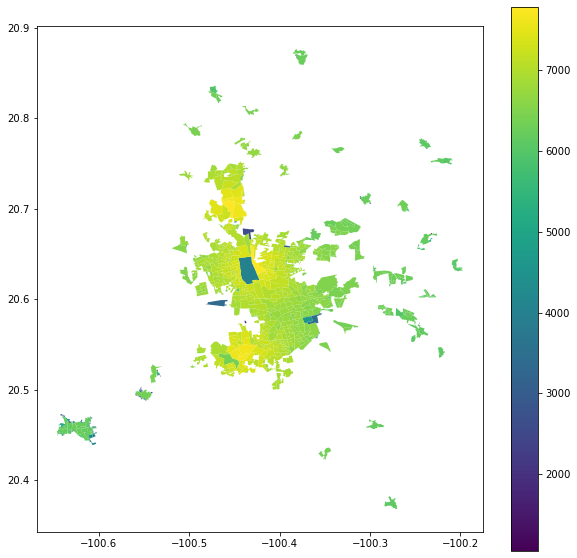

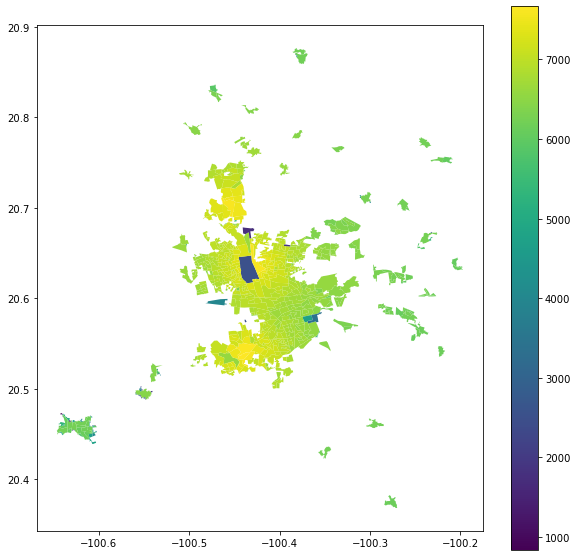

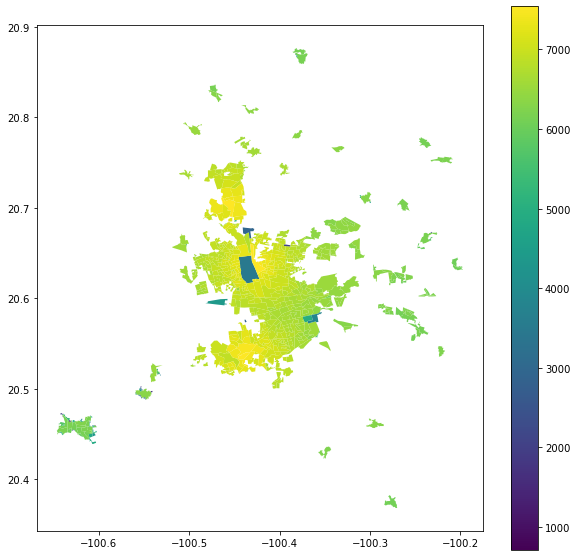

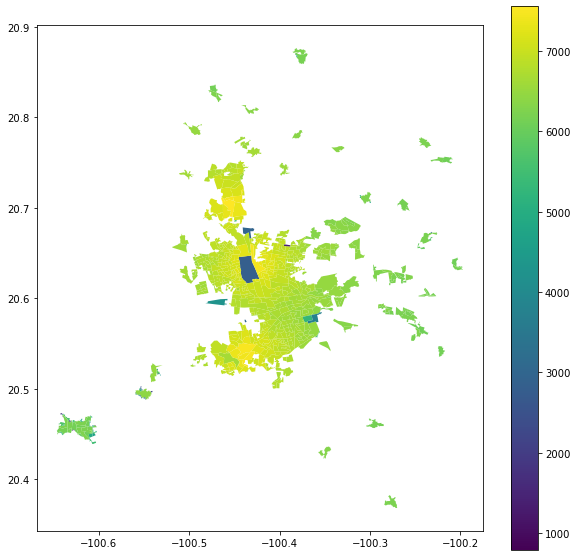

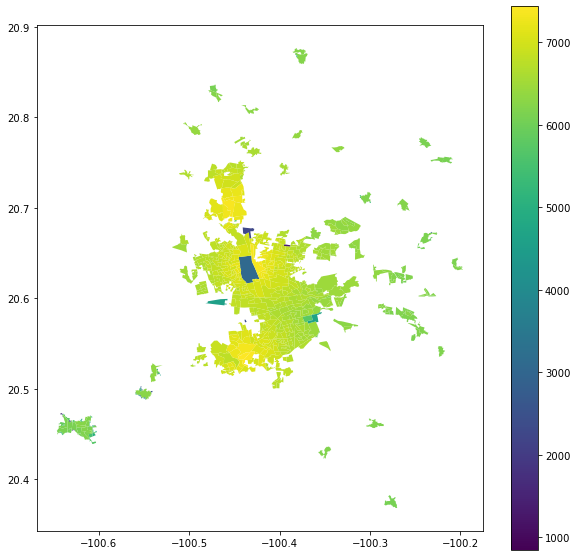

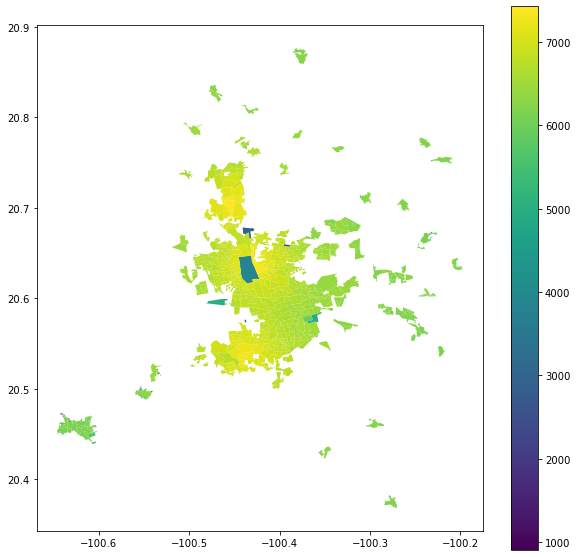

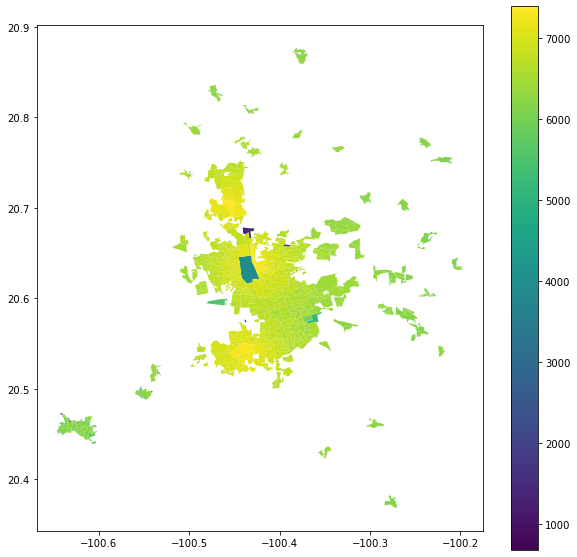

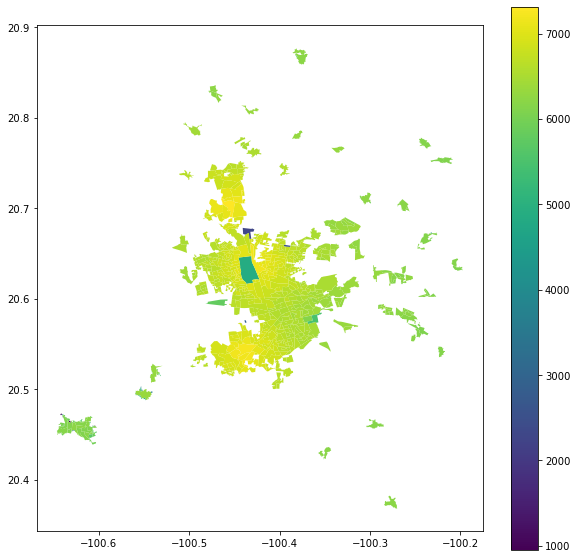

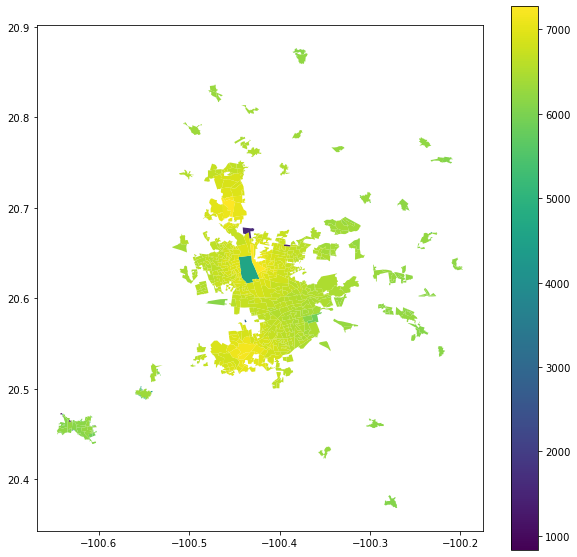

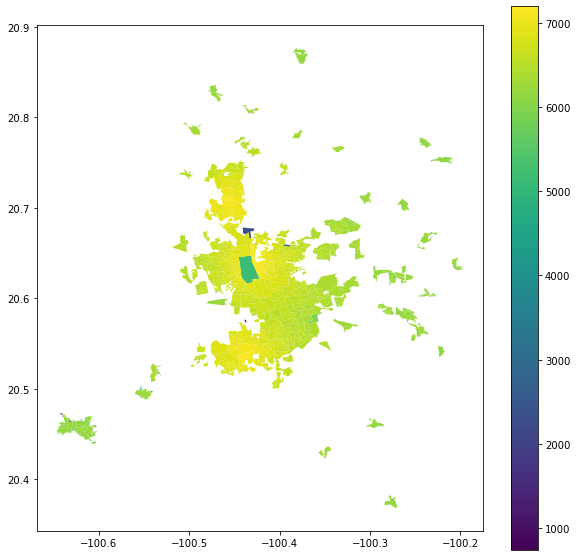

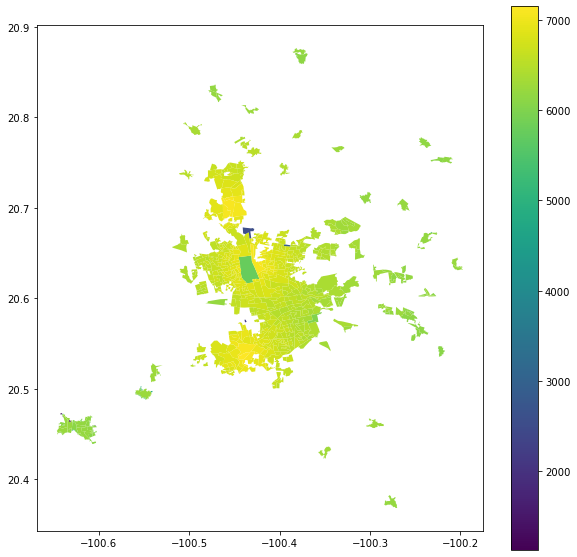

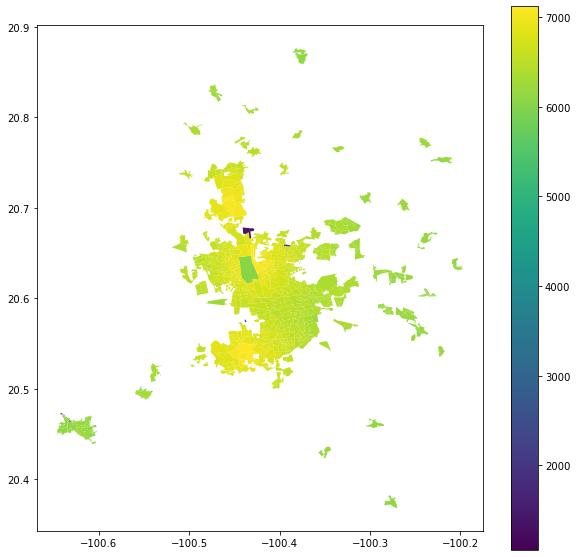

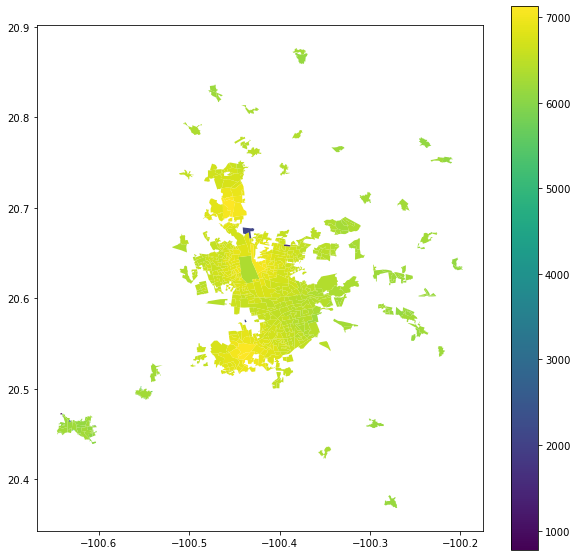

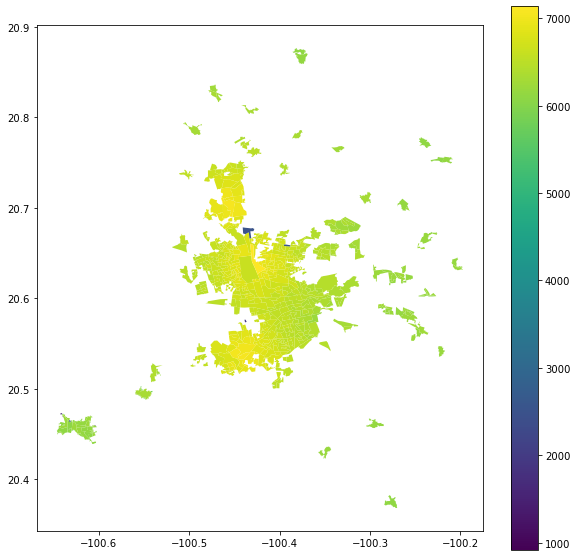

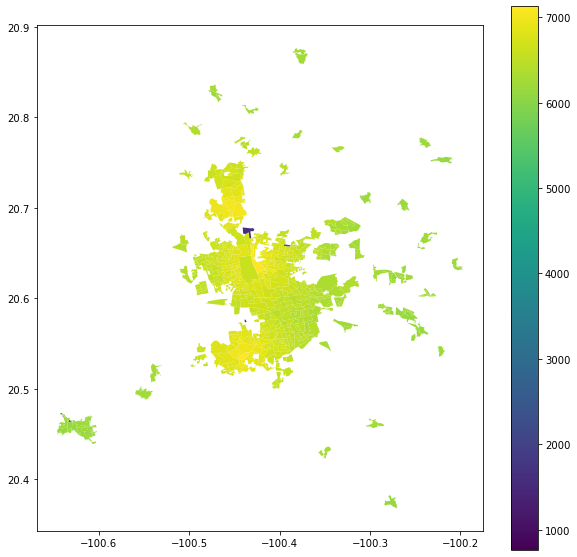

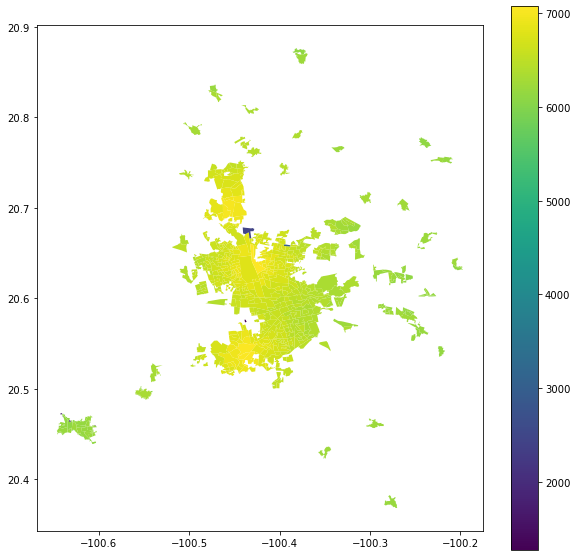

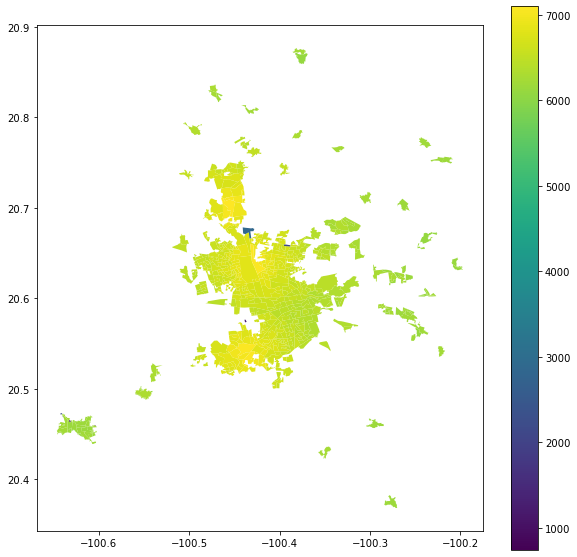

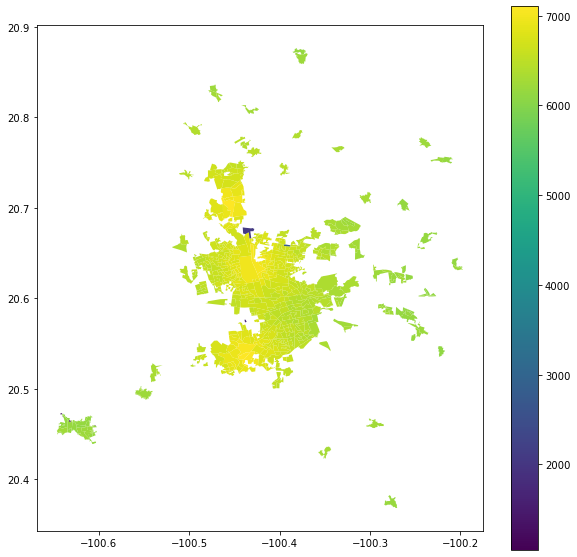

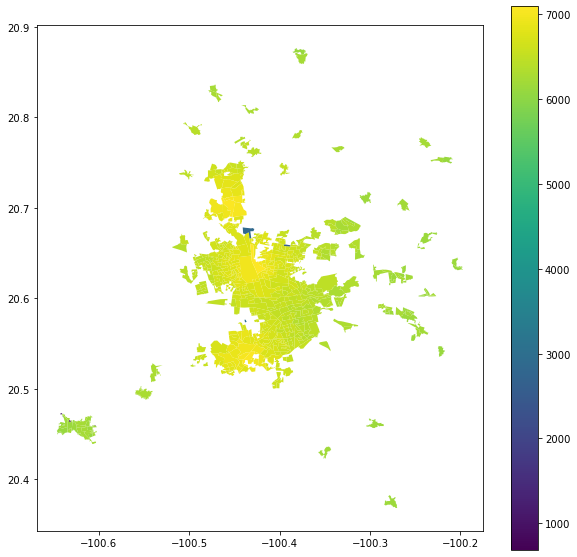

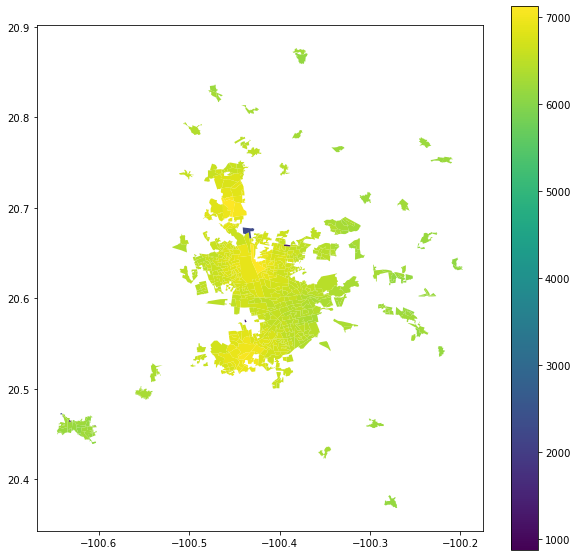

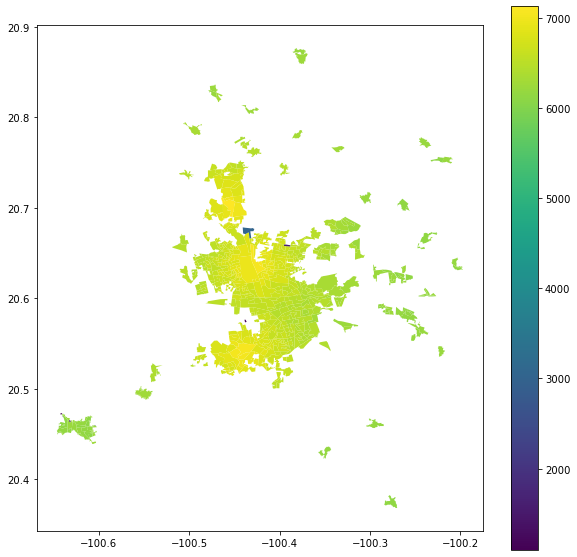

In [331]:
for i in range(50):
    print(i)
    agebs_net.plot_poblacion(i)
    plt.savefig('qrto_'+str(i)+'.jpg')

In [321]:
agebs_net.agebs['110040065053A'].distancias_cbd,agebs_net.agebs['110040065053A'].distancias_min_cbd

({'juriquilla': 25659.928989714535,
  'pi_bj': 20914.89924348982,
  'elpueblito': 13495.870775518113},
 13495.870775518113)

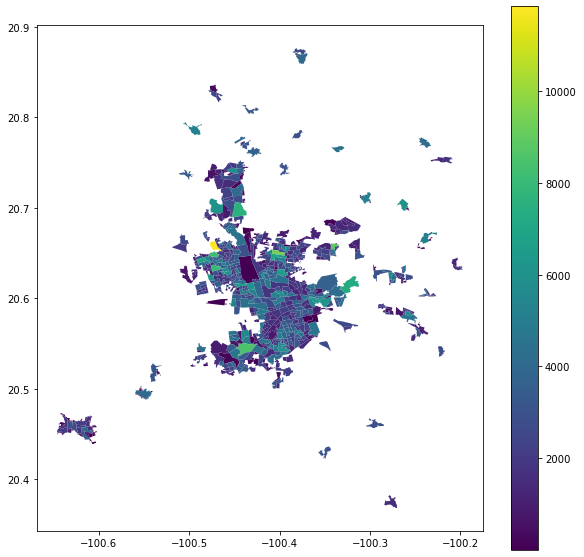

In [ ]:
n=30
b=0.5
p_oei=np.zeros((n,n))
for i in range(n):
    for j in range(n): 
    #distancia al centro
    r=dist[i][j]
    p_oei[i][j]=np.exp(-b*r)
    
p_oei=p_oei/np.sum(p_oei) 

In [ ]:
## Pensemos que la población en este ageb crece en 2%
for t in range(10):
    agebs_net.agebs['220140001038A'].poblacion[t+1]= (1+0.02) * agebs_net.agebs['220140001038A'].poblacion[t]
    
agebs_net.agebs['220140001038A'].poblacion

In [ ]:
## Observamos información de los vecinos de un ageb
for vecino in agebs_net.agebs['220140001038A'].vecinos:
    print("El ageb de 220140001038A con población {} tiene por vecino a la ageb {} con población {}".format(agebs_net.agebs['220140001038A'].poblacion[0],vecino.cvegeo,vecino.poblacion[0]))

In [ ]:
## La población de todos los agebs crece al 2% por 10 periodos
for t in range(10):
    print(t)
    for ageb in agebs_net.agebs:
        agebs_net.agebs[ageb].poblacion[t+1] = (1+.002)*agebs_net.agebs[ageb].poblacion[t] 
agebs_net.agebs['1100400010737'].poblacion